In [21]:
import numpy as np
import pandas as pd
import seaborn as sns

# import data processing modules
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor

# import model selection modules
from sklearn.model_selection import cross_val_score

# import data modeling modules
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [2]:
training_data = pd.read_csv('train.csv')

We'll begin a simple transformation pipeline: one-hot encode all categorical variables, impute median of missing continuous variables, and then standardize.

In [3]:
y = training_data['SalePrice']
X = training_data.drop(columns=['Id', 'SalePrice'], inplace=False)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('most_common', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

cat_features = list(X.columns[X.dtypes == 'object'])
num_features = list(X.columns[X.dtypes != 'object'])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('missing-indicator', MissingIndicator(error_on_new=False), list(X.columns))
])

X_piped = full_pipeline.fit_transform(X)

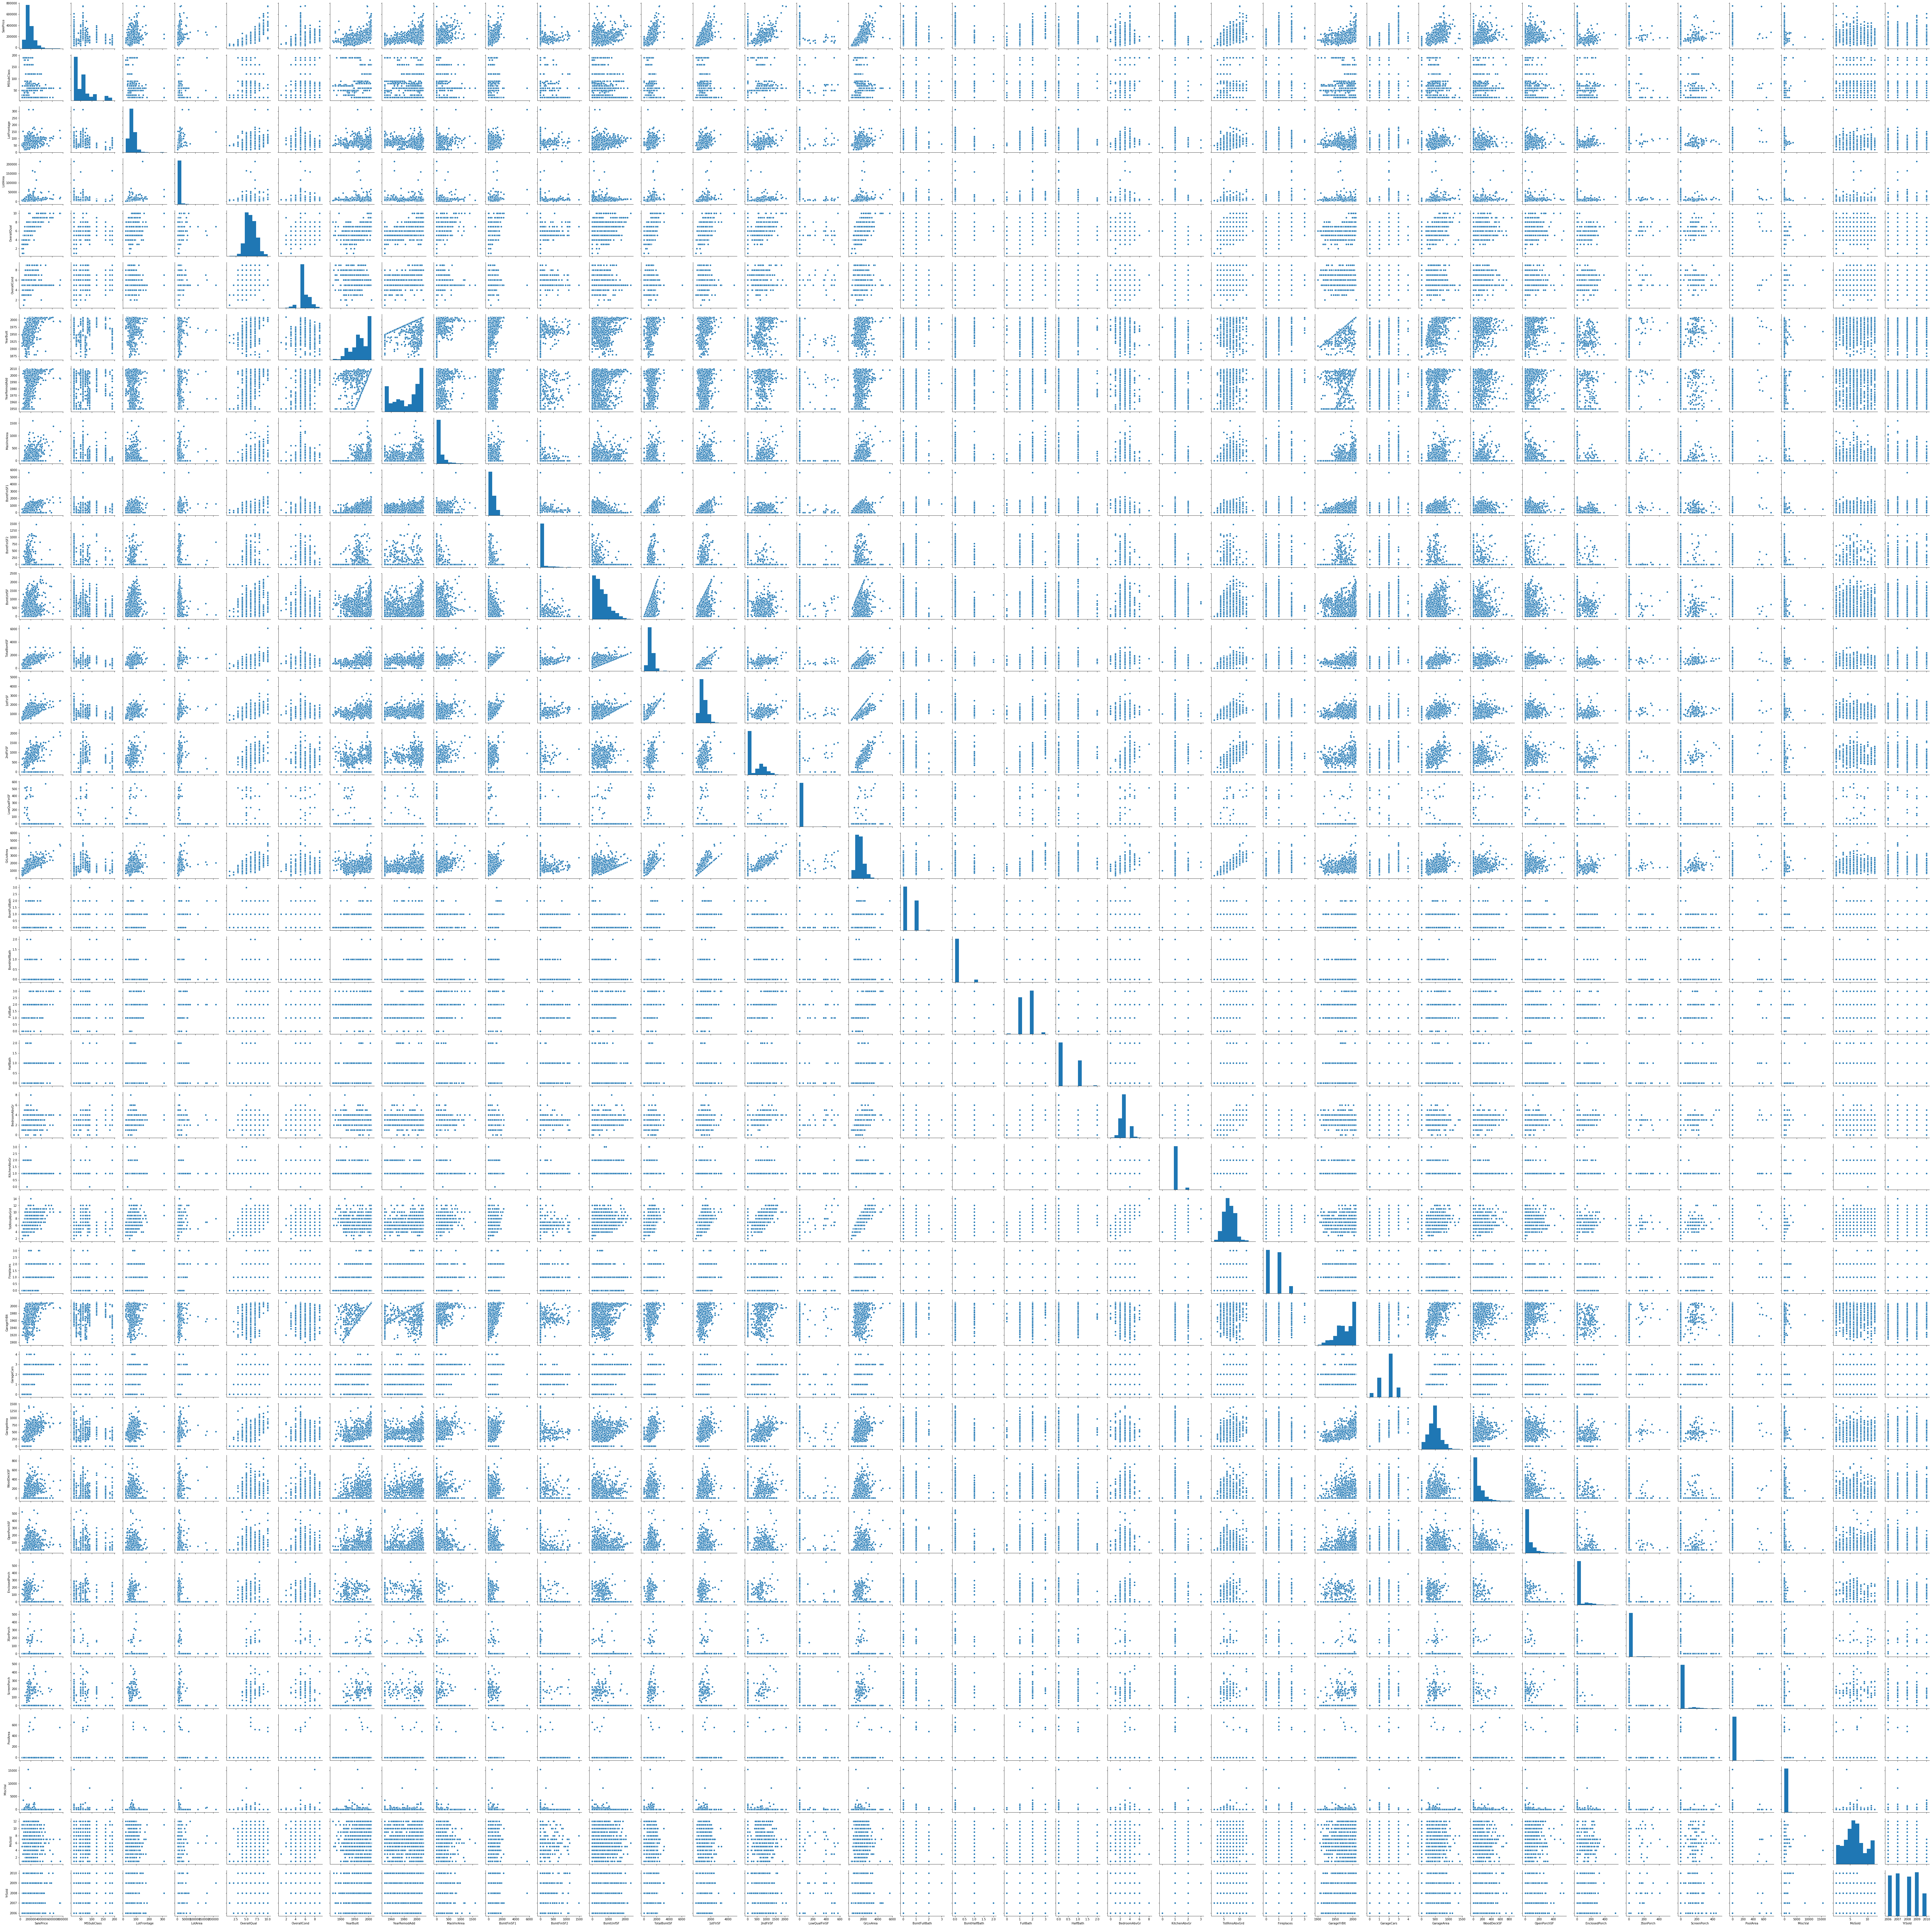

In [29]:
sns.pairplot(training_data[['SalePrice'] + num_features])

In [4]:
def cv(model, data, labels, scoring='neg_mean_squared_error', cv=10):
    """ 
    Perform cross-validation on model and return average error-rate
    """
    scores = cross_val_score(model, data, labels, scoring=scoring, cv=cv)
    return np.mean(np.sqrt(-scores))

In [5]:
def best_model(models, data, labels):
    """
    Perform cross-validation on all models in [models] and 
    return model with best cv score
    """
    model_scores = []
    for model in models:
        model_scores.append((model, cv(model, data, labels)))
    return model_scores

In [6]:
def get_best_model(model_scores, data=X_piped, y=y):
    best_to_worst = sorted(model_scores, key = lambda x: x[1])
    best = best_to_worst[0][0]
    best_fitted = best.fit(X_piped, y)
    return best_fitted

In [7]:
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), SVR(), MLPRegressor()]

In [8]:
model_scores = best_model(models, X_piped, y)

In [9]:
best_model = get_best_model(model_scores)

In [10]:
best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [11]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'bootstrap': [True, False],
    'n_estimators': [10, 100, 1000],
    'max_leaf_nodes': [10, 100, 1000, None]
    }


rand_forest_reg = RandomForestRegressor()

grid_search = RandomizedSearchCV(rand_forest_reg, 
                                 param_grid, cv=5,
                                 scoring='neg_mean_squared_error',
                                 return_train_score=True)
grid_search.fit(X_piped, y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [31]:
test_data = pd.read_csv('test.csv')
test_ids = test_data['Id']
test_data.drop(columns=['Id'], inplace=True)
test_processed = full_pipeline.transform(test_data)
test_predictions = best_model.predict(test_processed)
grid_predictions = grid_search.predict(test_processed)

In [32]:
predictions = pd.DataFrame({'id': test_ids, 'SalePrice': test_predictions})
predictions.to_csv('submissions.csv',index=False)

grid_predictions = pd.DataFrame({'id': test_ids, 'SalePrice': grid_predictions})
grid_predictions.to_csv('grid_submissions.csv',index=False)

from joblib import dump
dump(predictions, 'predictions_random_forest.joblib')
dump(grid_predictions, 'predictions_grid_search_random_forests.joblib')

['predictions_grid_search_random_forests.joblib']

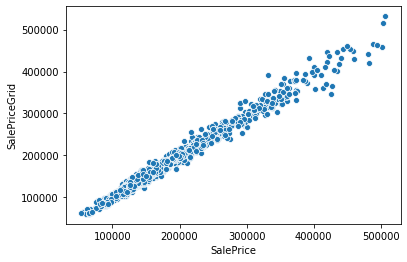

In [24]:
# inspect correlation between predictions
pred_join = pd.merge(predictions, grid_predictions, how='inner', on='id')
pred_join.columns = ['id', 'SalePrice', 'SalePriceGrid']
sns.scatterplot(x="SalePrice", y="SalePriceGrid", data=pred_join)